# OpenAlex
## Getting Started with the APS dataset
### Satyaki Sikdar (ssikdar@iu.edu) 
### Mar 1, 2022

This notebook is a getting started guide for getting familiar with the OpenAlex databases. 
The OpenAlex database has over 200 million papers and ~2 billion citations. 

To keep things manageable, we will focus on a smaller snapshot of the dataset which only covers the papers published by the APS. 

In [61]:
# load libraries 
import pandas as pd 
from pathlib import Path
import igraph as ig
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import networkx as nx
import numpy as np

tqdm.pandas()
plt.rcParams.update({'font.size': 22})
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

In [6]:
# set paths 
basepath: Path = Path('/N/project/openalex')
aps_csv_path = basepath / 'APS' / 'csvs'  # directory containing CSVs
aps_parq_path = basepath / 'APS' / 'parquets'  # directory containing parquet files

In [7]:
# some helper functions 
def read_parquet(name, **args):
    path = aps_parq_path / name
    df = pd.read_parquet(path, engine='pyarrow')
    df.reset_index(inplace=True)
    if '__null_dask_index__' in df.columns:
        df.drop(['__null_dask_index__'], axis=1, inplace=True)
    if 'index' in df.columns:
        df.drop(['index'], axis=1, inplace=True)
    df.drop_duplicates(inplace=True)
    
    if 'index_col' in args:
        df.set_index(args['index_col'], inplace=True)
    print(f'Read {len(df):,} rows from {path.stem!r}')
    return df 


def read_csv(name, **args):
    path = aps_csv_path / f'{name}.csv.gz'
    df = pd.read_csv(path, **args)
    df.drop_duplicates(inplace=True)
    print(f'Read {len(df):,} rows from {path.stem!r}')
    return df 


def to_parquet(df, path, **args):
    print(f'Writing {len(df):,} rows to {path.stem!r}')
    df.to_parquet(path, engine='pyarrow', index=False, **args)
    return

## Dataframes

####  Notes: 
1. Every table exists in two formats: CSV and Parquet. CSVs are good for humans while Parquets are more efficient. You may use either format. 

2. Each work, venue, author, institution, and concept are assigned **unique** IDs. 

4. The following relationship between the objects are defined. 
* `works_authorships`: relates works and authors (with institution info). Note: a (work_id, author_id) does not uniquely identify a row because an author may have multiple affiliations on a single paper. 

* `aps_referenced_aps`: relates works `w_1` and `w_2` if `w_1` cites `w_2`. Important: both `w_1` and `w_2` are published in the APS. 

* `works_concepts`: relates works with concepts. Note: a work may have multiple concepts. 

* `concepts_ancestors`: relates a pair of concepts `c_1` and `c_2` if `c_2` is an ancestor of `c_1` in the hierarchy of concepts

* `concepts_related_concepts`: relates a pair of concepts `c_1` and `c_2` if `c_1` is related to `c_2`

In [8]:
aps_works_df = read_parquet('works')  # read the works db
## or equivalently aps_works_df = read_csv('works')
aps_works_df.head(3)

Read 688,288 rows from 'works'


,work_id,venue_id,venue_name,doi,title,publication_year,publication_date,type,abstract
0,https://openalex.org/W2945786111,https://openalex.org/V6791298,Physical Review B,None,Comment on Field emission as a probe of the su...,1976,1976-07-15,journal-article,None
1,https://openalex.org/W2254473369,https://openalex.org/V6791298,Physical Review B,None,Magnetic Behavior of Kondo-Lattice System CeRu...,1983,1983-01-01,journal-article,None
2,https://openalex.org/W2782019466,https://openalex.org/V6791298,Physical Review B,None,Spectroscopy and electronic structure of Sr2YR...,2016,2016-01-01,journal-article,None


In [9]:
concepts_df = read_parquet('concepts')
concepts_df.head()

Read 13,138 rows from 'concepts'


,id,wikidata,display_name,level,description,works_count,cited_by_count
0,https://openalex.org/C100185428,https://www.wikidata.org/wiki/Q5168010,Coordinate time,3,Time scale,14,59
1,https://openalex.org/C2991911461,https://www.wikidata.org/wiki/Q386272,Feynman graph,2,pictorial representations of the behavior of s...,9,138
2,https://openalex.org/C194405637,https://www.wikidata.org/wiki/Q369367,Repetition code,5,<NA>,4,57
3,https://openalex.org/C13568960,https://www.wikidata.org/wiki/Q5073777,K-alpha,3,<NA>,278,3326
4,https://openalex.org/C94231801,https://www.wikidata.org/wiki/Q653850,Probability amplitude,5,complex number whose squared absolute value is...,46,477


In [10]:
aps_authors_df = read_parquet('works_authorships')
aps_authors_df.head(3)

Read 3,445,203 rows from 'works_authorships'


,work_id,title,publication_year,author_id,author_name,author_position,institution_id,institution_name
0,https://openalex.org/W2945786111,Comment on Field emission as a probe of the su...,1976,https://openalex.org/A2096989079,David R. Penn,first,<NA>,<NA>
1,https://openalex.org/W2043929483,Electron mean-free-path calculations using a m...,1987,https://openalex.org/A2096989079,David R. Penn,first,https://openalex.org/I1321296531,National Institute of Standards and Technology
2,https://openalex.org/W2063105163,Mean free paths of very-low-energy electrons: ...,1980,https://openalex.org/A2096989079,David R. Penn,first,https://openalex.org/I1321296531,National Institute of Standards and Technology


In [11]:
aps_refs_df = read_parquet('aps_referenced_aps')
aps_refs_df.head(3)

Read 3,162,282 rows from 'aps_referenced_aps'


,work_id,referenced_work_id
0,https://openalex.org/W2947567950,https://openalex.org/W1990720130
1,https://openalex.org/W2947567950,https://openalex.org/W1967840041
2,https://openalex.org/W2947567950,https://openalex.org/W2042302158


In [12]:
works_concepts_df = read_parquet('works_concepts')
works_concepts_df.head(3)  

Read 6,027,621 rows from 'works_concepts'


,work_id,concept_id,concept_name,score
0,https://openalex.org/W2945786111,https://openalex.org/C111219384,NIST,0.667155
1,https://openalex.org/W2900141038,https://openalex.org/C111219384,NIST,0.561844
2,https://openalex.org/W2626305166,https://openalex.org/C111219384,NIST,0.719397


In [100]:
concepts_ancestors_df = read_parquet('concepts_ancestors')
concepts_ancestors_df

Read 76,057 rows from 'concepts_ancestors'


,concept_id,ancestor_id,concept_name,ancestor_concept_name
0,https://openalex.org/C100185428,https://openalex.org/C80551277,Coordinate time,Coordinate system
1,https://openalex.org/C100185428,https://openalex.org/C147452769,Coordinate time,General relativity
2,https://openalex.org/C100185428,https://openalex.org/C60229501,Coordinate time,Global Positioning System
3,https://openalex.org/C100185428,https://openalex.org/C149324446,Coordinate time,Theory of relativity
4,https://openalex.org/C100185428,https://openalex.org/C154945302,Coordinate time,Artificial intelligence
...,...,...,...,...
76052,https://openalex.org/C3020698628,https://openalex.org/C178790620,Hyperfine coupling,Organic chemistry
76053,https://openalex.org/C3020698628,https://openalex.org/C62520636,Hyperfine coupling,Quantum mechanics
76054,https://openalex.org/C3020698628,https://openalex.org/C86803240,Hyperfine coupling,Biology
76055,https://openalex.org/C3020698628,https://openalex.org/C185592680,Hyperfine coupling,Chemistry


## Making graphs using iGraph

We have a few options on what graphs we want to construct. To keep things simple, we'll construct a citation graph using `igraph`.
`aps_refs_df` is essentially an edge list. 

Let's create a node dataframe which would have necessary node info. 

In [101]:
aps_works_df

,work_id,venue_id,venue_name,doi,title,publication_year,publication_date,type,abstract
0,https://openalex.org/W2945786111,https://openalex.org/V6791298,Physical Review B,NaN,Comment on Field emission as a probe of the su...,1976,1976-07-15,journal-article,NaN
1,https://openalex.org/W2254473369,https://openalex.org/V6791298,Physical Review B,NaN,Magnetic Behavior of Kondo-Lattice System CeRu...,1983,1983-01-01,journal-article,NaN
2,https://openalex.org/W2782019466,https://openalex.org/V6791298,Physical Review B,NaN,Spectroscopy and electronic structure of Sr2YR...,2016,2016-01-01,journal-article,NaN
3,https://openalex.org/W1612831857,https://openalex.org/V6791298,Physical Review B,https://doi.org/10.1103/physrevb.37.2618,Metallic CaSi2 epitaxial films on Si(111).,1988,1988-02-15,journal-article,NaN
4,https://openalex.org/W1615049408,https://openalex.org/V6791298,Physical Review B,https://doi.org/10.1103/physrevb.71.134425,Anomalous Hall effects in amorphousNi74Mn24Pt2...,2005,2005-04-29,journal-article,NaN
...,...,...,...,...,...,...,...,...,...
688283,https://openalex.org/W4206764813,https://openalex.org/V4210235286,Physical Review,https://doi.org/10.1103/physreve.104.064135,Microemulsions in the driven Widom-Rowlinson l...,2021,2021-12-27,journal-article,An investigation of the two-dimensional Widom-...
688284,https://openalex.org/W4211033296,https://openalex.org/V4210208989,Physical Review,https://doi.org/10.1103/physrevb.16.4853,Shunted-Josephson-junction model. I. The auton...,1977,1977-12-01,journal-article,NaN
688285,https://openalex.org/W4210957530,https://openalex.org/V4210208989,Physical Review,https://doi.org/10.1103/physrevb.5.3370.3,Optical Properties of Single-Crystal Cadmium,1972,1972-04-15,journal-article,NaN
688286,https://openalex.org/W4205808126,https://openalex.org/V4210208989,Physical Review,https://doi.org/10.1103/physrevb.3.3080,Reduction in Page Charges,1971,1971-05-01,journal-article,NaN


In [9]:
nodes_df = aps_works_df[['work_id', 'venue_id', 'venue_name', 'title', 'publication_year', 'abstract']]  # change this according to your needs

In [10]:
nodes_df

,work_id,venue_id,venue_name,title,publication_year,abstract
0,https://openalex.org/W2945786111,https://openalex.org/V6791298,Physical Review B,Comment on Field emission as a probe of the su...,1976,None
1,https://openalex.org/W2254473369,https://openalex.org/V6791298,Physical Review B,Magnetic Behavior of Kondo-Lattice System CeRu...,1983,None
2,https://openalex.org/W2782019466,https://openalex.org/V6791298,Physical Review B,Spectroscopy and electronic structure of Sr2YR...,2016,None
3,https://openalex.org/W1612831857,https://openalex.org/V6791298,Physical Review B,Metallic CaSi2 epitaxial films on Si(111).,1988,None
4,https://openalex.org/W1615049408,https://openalex.org/V6791298,Physical Review B,Anomalous Hall effects in amorphousNi74Mn24Pt2...,2005,None
...,...,...,...,...,...,...
688283,https://openalex.org/W4206764813,https://openalex.org/V4210235286,Physical Review,Microemulsions in the driven Widom-Rowlinson l...,2021,An investigation of the two-dimensional Widom-...
688284,https://openalex.org/W4211033296,https://openalex.org/V4210208989,Physical Review,Shunted-Josephson-junction model. I. The auton...,1977,None
688285,https://openalex.org/W4210957530,https://openalex.org/V4210208989,Physical Review,Optical Properties of Single-Crystal Cadmium,1972,None
688286,https://openalex.org/W4205808126,https://openalex.org/V4210208989,Physical Review,Reduction in Page Charges,1971,None


In [11]:
cite_g = ig.Graph.DataFrame(edges=aps_refs_df, vertices=nodes_df, directed=True)
print(cite_g.summary())

IGRAPH DN-- 688288 3162282 -- 
+ attr: abstract (v), name (v), publication_year (v), title (v), venue_id (v), venue_name (v)


We have a graph!

Node attributes can be accessed using the `vertex_property` dictionary. Refer to [this link](https://igraph.org/python/tutorial/latest/tutorial.html#querying-vertices-and-edges-based-on-attributes) for more info. 

In [12]:
print(cite_g.vs.attribute_names())  # name has the work_ids

['name', 'venue_id', 'venue_name', 'title', 'publication_year', 'abstract']


In [13]:
example_work_id = 'https://openalex.org/W3086477784'
print('Node IDs:', cite_g.neighbors(example_work_id, mode='out'))  # list the outgoing neighbors of this node

# to get names of the nodes, use the cite_g.vs
print('Node names:', [cite_g.vs[u]['name'] for u in cite_g.neighbors(example_work_id, mode='out')])  # similarly for titles, abstract, etc.

Node IDs: [643615, 644680, 645212, 645219, 646130, 649024]
Node names: ['https://openalex.org/W1964846359', 'https://openalex.org/W2095293504', 'https://openalex.org/W1995996823', 'https://openalex.org/W2132202037', 'https://openalex.org/W2023655578', 'https://openalex.org/W2082459856']


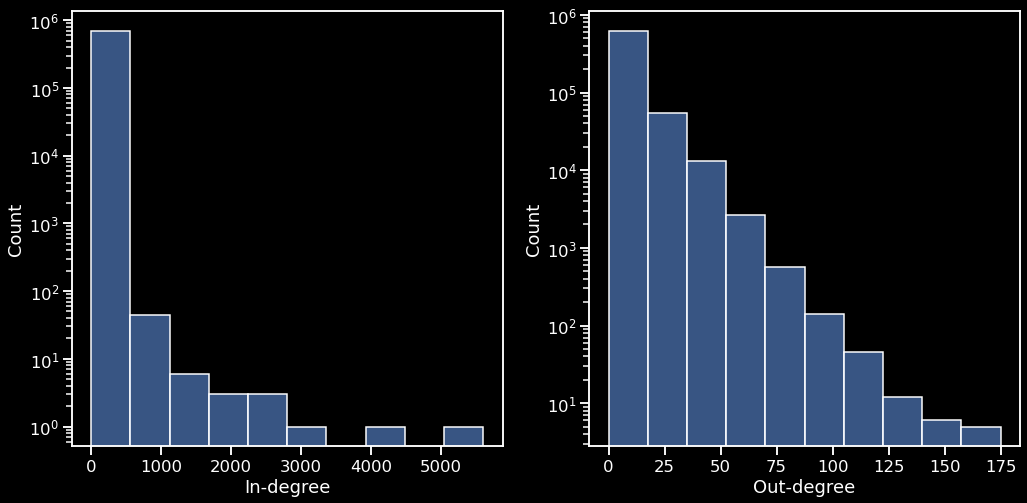

In [16]:
# compute the degree distributions
in_degrees= [cite_g.degree(v, 'in') for v in cite_g.vs]
out_degrees= [cite_g.degree(v, 'out') for v in cite_g.vs]

fig, (ax1, ax2) = plt.subplots(figsize=(17, 8), ncols=2)
sns.histplot(in_degrees, bins=10, ax=ax1);
sns.histplot(out_degrees, bins=10, ax=ax2);

ax1.set_xlabel('In-degree')
ax1.set_yscale('log');

ax2.set_xlabel('Out-degree')
ax2.set_yscale('log');

In [17]:
clusters = cite_g.clusters(mode='weak')

In [18]:
lcc_g = clusters.giant()
print(lcc_g.summary())

IGRAPH DN-- 496506 3161247 -- 
+ attr: abstract (v), name (v), publication_year (v), title (v), venue_id (v), venue_name (v)


## Co-authorship graphs

In [9]:
aps_authors_df

,work_id,title,publication_year,author_id,author_name,author_position,institution_id,institution_name
0,https://openalex.org/W2945786111,Comment on Field emission as a probe of the su...,1976,https://openalex.org/A2096989079,David R. Penn,first,<NA>,<NA>
1,https://openalex.org/W2043929483,Electron mean-free-path calculations using a m...,1987,https://openalex.org/A2096989079,David R. Penn,first,https://openalex.org/I1321296531,National Institute of Standards and Technology
2,https://openalex.org/W2063105163,Mean free paths of very-low-energy electrons: ...,1980,https://openalex.org/A2096989079,David R. Penn,first,https://openalex.org/I1321296531,National Institute of Standards and Technology
3,https://openalex.org/W2000423142,Role of Intrinsic Plasmons in Conduction-Band ...,1978,https://openalex.org/A2096989079,David R. Penn,first,<NA>,<NA>
4,https://openalex.org/W2082795266,Theory of spin-polarized secondary electrons i...,1985,https://openalex.org/A2096989079,David R. Penn,first,https://openalex.org/I1321296531,National Institute of Standards and Technology
...,...,...,...,...,...,...,...,...
3445199,https://openalex.org/W3207113520,Signature of nonuniform area quantization on g...,2021,https://openalex.org/A3189257609,Kabir Chakravarti,first,https://openalex.org/I27674431,Indian Institute of Technology Gandhinagar
3445200,https://openalex.org/W3134653963,Theory for size segregation in flowing granula...,2021,https://openalex.org/A2727836454,Mohit Nema,middle,https://openalex.org/I94234084,Indian Institute of Technology Kanpur
3445201,https://openalex.org/W3134780308,Decomposition of the transition phase in multi...,2021,https://openalex.org/A3036804719,Divya Bharti,first,https://openalex.org/I149899117,Max Planck Society
3445202,https://openalex.org/W3134780308,Decomposition of the transition phase in multi...,2021,https://openalex.org/A3010336175,Gavin Menning,middle,https://openalex.org/I87213936,Drake University


In [11]:
work_id = 'https://openalex.org/W3134780308'
aps_authors_df.query(f'work_id==@work_id')[['author_id', 'author_name']]

,author_id,author_name
123432,https://openalex.org/A2302262113,Klaus Bartschat
227042,https://openalex.org/A2134211347,Thomas Pfeifer
1314979,https://openalex.org/A2935418574,Robert Moshammer
1961585,https://openalex.org/A2996040886,Kathryn R. Hamilton
2461421,https://openalex.org/A3180564053,N. Douguet
3014009,https://openalex.org/A2468522034,Anne Harth
3033845,https://openalex.org/A3095525600,David Atri-Schuller
3445201,https://openalex.org/A3036804719,Divya Bharti
3445202,https://openalex.org/A3010336175,Gavin Menning


In [42]:
author_counts = aps_authors_df.groupby('work_id').count()['author_id'].to_dict()  # no of authors for a paper

In [14]:
aps_authors_df.groupby('author_id').count()['work_id']  # no of authors for a paper

author_id
https://openalex.org/A100017046      3
https://openalex.org/A100027360      1
https://openalex.org/A1000441957     5
https://openalex.org/A1000448776     4
https://openalex.org/A100047651      2
                                    ..
https://openalex.org/A99888573       1
https://openalex.org/A998942454      2
https://openalex.org/A998973380     17
https://openalex.org/A99925565      22
https://openalex.org/A99993189      16
Name: work_id, Length: 700688, dtype: int64

In [35]:
df = aps_authors_df.groupby('work_id')['author_id'].apply(list).reset_index()

In [37]:
df

,work_id,author_id
0,https://openalex.org/W100001730,"[https://openalex.org/A2143571431, https://ope..."
1,https://openalex.org/W1000096099,"[https://openalex.org/A3164194267, https://ope..."
2,https://openalex.org/W1000107713,"[https://openalex.org/A2096112280, https://ope..."
3,https://openalex.org/W100017273,"[https://openalex.org/A2655867334, https://ope..."
4,https://openalex.org/W1000197900,[https://openalex.org/A2631810047]
...,...,...
688221,https://openalex.org/W999118201,"[https://openalex.org/A2699955109, https://ope..."
688222,https://openalex.org/W99919431,"[https://openalex.org/A2611107232, https://ope..."
688223,https://openalex.org/W99922069,"[https://openalex.org/A1997816908, https://ope..."
688224,https://openalex.org/W999863685,[https://openalex.org/A2505722911]


In [38]:
aps_refs_df

,work_id,referenced_work_id
0,https://openalex.org/W2947567950,https://openalex.org/W1990720130
1,https://openalex.org/W2947567950,https://openalex.org/W1967840041
2,https://openalex.org/W2947567950,https://openalex.org/W2042302158
3,https://openalex.org/W2947567950,https://openalex.org/W2047894457
4,https://openalex.org/W2947567950,https://openalex.org/W2018112712
...,...,...
3162277,https://openalex.org/W2409868476,https://openalex.org/W2123046843
3162278,https://openalex.org/W2409868476,https://openalex.org/W2127667145
3162279,https://openalex.org/W2409868476,https://openalex.org/W1502628325
3162280,https://openalex.org/W2409868476,https://openalex.org/W2012922008


In [52]:
aps_refs_df.loc[:, 'work_authors_count'] = aps_refs_df.work_id.apply(lambda w: 
                                                                     author_counts.get(w, 0))

aps_refs_df.loc[:, 'ref_work_authors_count'] = aps_refs_df.referenced_work_id.apply(lambda w: 
                                                                     author_counts.get(w, 0))
aps_refs_df

,work_id,referenced_work_id,work_authors_count,ref_work_authors_count
0,https://openalex.org/W2947567950,https://openalex.org/W1990720130,1,4
1,https://openalex.org/W2947567950,https://openalex.org/W1967840041,1,2
2,https://openalex.org/W2947567950,https://openalex.org/W2042302158,1,2
3,https://openalex.org/W2947567950,https://openalex.org/W2047894457,1,2
4,https://openalex.org/W2947567950,https://openalex.org/W2018112712,1,2
...,...,...,...,...
3162277,https://openalex.org/W2409868476,https://openalex.org/W2123046843,3,3
3162278,https://openalex.org/W2409868476,https://openalex.org/W2127667145,3,3
3162279,https://openalex.org/W2409868476,https://openalex.org/W1502628325,3,3
3162280,https://openalex.org/W2409868476,https://openalex.org/W2012922008,3,1


In [53]:
aps_refs_df.work_authors_count.value_counts().reset_index().sort_values(by='index')

,index,work_authors_count
40,0,515
4,1,240312
1,2,645555
0,3,667659
2,4,502658
...,...,...
86,96,136
94,97,93
69,98,231
68,99,236


In [54]:
aps_refs_df.ref_work_authors_count.value_counts().reset_index().sort_values(by='index')

,index,ref_work_authors_count
100,0,10
3,1,348918
0,2,746978
1,3,649182
2,4,442120
...,...,...
90,96,117
93,97,107
57,98,380
58,99,365


In [55]:
aps_refs_df

,work_id,referenced_work_id,work_authors_count,ref_work_authors_count
0,https://openalex.org/W2947567950,https://openalex.org/W1990720130,1,4
1,https://openalex.org/W2947567950,https://openalex.org/W1967840041,1,2
2,https://openalex.org/W2947567950,https://openalex.org/W2042302158,1,2
3,https://openalex.org/W2947567950,https://openalex.org/W2047894457,1,2
4,https://openalex.org/W2947567950,https://openalex.org/W2018112712,1,2
...,...,...,...,...
3162277,https://openalex.org/W2409868476,https://openalex.org/W2123046843,3,3
3162278,https://openalex.org/W2409868476,https://openalex.org/W2127667145,3,3
3162279,https://openalex.org/W2409868476,https://openalex.org/W1502628325,3,3
3162280,https://openalex.org/W2409868476,https://openalex.org/W2012922008,3,1


In [60]:
import numpy as np

In [61]:
def calculate_weights(row):
    m = row.work_authors_count
    n = row.ref_work_authors_count
    if m == 0 or n == 0:
        return np.nan
    else:
        return 1 / (m * n)

In [65]:
aps_refs_df.loc[:, 'weight'] = aps_refs_df.progress_apply(lambda row: calculate_weights(row),axis=1)

  0%|          | 0/3162282 [00:00<?, ?it/s]

In [66]:
aps_refs_df

,work_id,referenced_work_id,work_authors_count,ref_work_authors_count,weight
0,https://openalex.org/W2947567950,https://openalex.org/W1990720130,1,4,0.250000
1,https://openalex.org/W2947567950,https://openalex.org/W1967840041,1,2,0.500000
2,https://openalex.org/W2947567950,https://openalex.org/W2042302158,1,2,0.500000
3,https://openalex.org/W2947567950,https://openalex.org/W2047894457,1,2,0.500000
4,https://openalex.org/W2947567950,https://openalex.org/W2018112712,1,2,0.500000
...,...,...,...,...,...
3162277,https://openalex.org/W2409868476,https://openalex.org/W2123046843,3,3,0.111111
3162278,https://openalex.org/W2409868476,https://openalex.org/W2127667145,3,3,0.111111
3162279,https://openalex.org/W2409868476,https://openalex.org/W1502628325,3,3,0.111111
3162280,https://openalex.org/W2409868476,https://openalex.org/W2012922008,3,1,0.333333


In [67]:

aps_refs_df[aps_refs_df.weight.isna()]

,work_id,referenced_work_id,work_authors_count,ref_work_authors_count,weight
1123734,https://openalex.org/W4205280470,https://openalex.org/W2915737249,0,100,NaN
1123735,https://openalex.org/W4205280470,https://openalex.org/W2172168240,0,3,NaN
1123736,https://openalex.org/W4205280470,https://openalex.org/W3037653575,0,4,NaN
1123737,https://openalex.org/W4205280470,https://openalex.org/W3211627276,0,100,NaN
1123738,https://openalex.org/W4205280470,https://openalex.org/W1985315599,0,4,NaN
...,...,...,...,...,...
1543701,https://openalex.org/W4200424621,https://openalex.org/W3113966267,0,2,NaN
1543702,https://openalex.org/W4200424621,https://openalex.org/W3190924071,0,100,NaN
1543703,https://openalex.org/W4200424621,https://openalex.org/W1980302743,0,2,NaN
1543704,https://openalex.org/W4200424621,https://openalex.org/W2041281433,0,3,NaN


In [78]:
df = aps_authors_df.head(100)
pd.crosstab(df.author_id, df.work_id)

work_id,https://openalex.org/W1527881061,https://openalex.org/W1531110826,https://openalex.org/W1676760760,https://openalex.org/W1742726219,https://openalex.org/W1892468857,https://openalex.org/W1964161194,https://openalex.org/W1967015971,https://openalex.org/W1967663024,https://openalex.org/W1970191329,https://openalex.org/W1973942027,...,https://openalex.org/W2787315167,https://openalex.org/W282211693,https://openalex.org/W2899952361,https://openalex.org/W2903912084,https://openalex.org/W2945786111,https://openalex.org/W2973125817,https://openalex.org/W3046698277,https://openalex.org/W3117288486,https://openalex.org/W40503865,https://openalex.org/W87664294
author_id,,,,,,,,,,,,,,,,,,,,,
https://openalex.org/A2096989079,0,0,1,0,0,1,0,0,0,1,...,0,0,1,1,1,1,0,0,0,0
https://openalex.org/A2259130185,1,1,0,1,2,0,1,1,1,0,...,1,1,0,0,0,0,1,1,1,1
https://openalex.org/A2706093076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://openalex.org/A2805663295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://openalex.org/A3134815417,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
auth_id1 = 'https://openalex.org/A2259130185'
auth_id2 = 'https://openalex.org/A2489500432'
work_ids = aps_authors_df.query('author_id==@auth_id1')['work_id']
aps_authors_df.query('author_id==@auth_id2 & work_id.isin(@work_ids)').count()

work_id             32
title               32
publication_year    32
author_id           32
author_name         32
author_position     32
institution_id      28
institution_name    28
dtype: int64

In [83]:
cleaned_authors_df = aps_authors_df.drop_duplicates(subset=['work_id', 'author_id'])  # throw out authors with multiple affils
cleaned_authors_df

,work_id,title,publication_year,author_id,author_name,author_position,institution_id,institution_name
0,https://openalex.org/W2945786111,Comment on Field emission as a probe of the su...,1976,https://openalex.org/A2096989079,David R. Penn,first,<NA>,<NA>
1,https://openalex.org/W2043929483,Electron mean-free-path calculations using a m...,1987,https://openalex.org/A2096989079,David R. Penn,first,https://openalex.org/I1321296531,National Institute of Standards and Technology
2,https://openalex.org/W2063105163,Mean free paths of very-low-energy electrons: ...,1980,https://openalex.org/A2096989079,David R. Penn,first,https://openalex.org/I1321296531,National Institute of Standards and Technology
3,https://openalex.org/W2000423142,Role of Intrinsic Plasmons in Conduction-Band ...,1978,https://openalex.org/A2096989079,David R. Penn,first,<NA>,<NA>
4,https://openalex.org/W2082795266,Theory of spin-polarized secondary electrons i...,1985,https://openalex.org/A2096989079,David R. Penn,first,https://openalex.org/I1321296531,National Institute of Standards and Technology
...,...,...,...,...,...,...,...,...
3445199,https://openalex.org/W3207113520,Signature of nonuniform area quantization on g...,2021,https://openalex.org/A3189257609,Kabir Chakravarti,first,https://openalex.org/I27674431,Indian Institute of Technology Gandhinagar
3445200,https://openalex.org/W3134653963,Theory for size segregation in flowing granula...,2021,https://openalex.org/A2727836454,Mohit Nema,middle,https://openalex.org/I94234084,Indian Institute of Technology Kanpur
3445201,https://openalex.org/W3134780308,Decomposition of the transition phase in multi...,2021,https://openalex.org/A3036804719,Divya Bharti,first,https://openalex.org/I149899117,Max Planck Society
3445202,https://openalex.org/W3134780308,Decomposition of the transition phase in multi...,2021,https://openalex.org/A3010336175,Gavin Menning,middle,https://openalex.org/I87213936,Drake University


In [82]:
cleaned_authors_df.query('work_id==@work_id & author_id==@auth_id')

,work_id,title,publication_year,author_id,author_name,author_position,institution_id,institution_name
82,https://openalex.org/W1892468857,Unstable spin-ice order in the stuffed metalli...,2015,https://openalex.org/A2259130185,D. E. MacLaughlin,first,https://openalex.org/I74801974,University of Tokyo


In [97]:
df = cleaned_authors_df.head(500_000)
pair_count_df = pd.crosstab(df.author_id, df.author_id)

In [102]:
pair_count_df.unstack()

author_id                         author_id                       
https://openalex.org/A1004025477  https://openalex.org/A1004025477      7
                                  https://openalex.org/A101748621       0
                                  https://openalex.org/A102100166       0
                                  https://openalex.org/A1026450096      0
                                  https://openalex.org/A102731583       0
                                                                     ... 
https://openalex.org/A979737608   https://openalex.org/A970369149       0
                                  https://openalex.org/A974920409       0
                                  https://openalex.org/A975490132       0
                                  https://openalex.org/A97733193        0
                                  https://openalex.org/A979737608     329
Length: 101344489, dtype: int64

In [98]:
x = pair_count_df.to_numpy()
np.count_nonzero(x - np.diag(np.diagonal(x)))

0

## NetworkX 

Let's use NetworkX to construct bipartite graphs -- co-authorships, work-concepts

In [15]:
aps_authors_df

,work_id,title,publication_year,author_id,author_name,author_position,institution_id,institution_name
0,https://openalex.org/W2945786111,Comment on Field emission as a probe of the su...,1976,https://openalex.org/A2096989079,David R. Penn,first,<NA>,<NA>
1,https://openalex.org/W2043929483,Electron mean-free-path calculations using a m...,1987,https://openalex.org/A2096989079,David R. Penn,first,https://openalex.org/I1321296531,National Institute of Standards and Technology
2,https://openalex.org/W2063105163,Mean free paths of very-low-energy electrons: ...,1980,https://openalex.org/A2096989079,David R. Penn,first,https://openalex.org/I1321296531,National Institute of Standards and Technology
3,https://openalex.org/W2000423142,Role of Intrinsic Plasmons in Conduction-Band ...,1978,https://openalex.org/A2096989079,David R. Penn,first,<NA>,<NA>
4,https://openalex.org/W2082795266,Theory of spin-polarized secondary electrons i...,1985,https://openalex.org/A2096989079,David R. Penn,first,https://openalex.org/I1321296531,National Institute of Standards and Technology
...,...,...,...,...,...,...,...,...
3445199,https://openalex.org/W3207113520,Signature of nonuniform area quantization on g...,2021,https://openalex.org/A3189257609,Kabir Chakravarti,first,https://openalex.org/I27674431,Indian Institute of Technology Gandhinagar
3445200,https://openalex.org/W3134653963,Theory for size segregation in flowing granula...,2021,https://openalex.org/A2727836454,Mohit Nema,middle,https://openalex.org/I94234084,Indian Institute of Technology Kanpur
3445201,https://openalex.org/W3134780308,Decomposition of the transition phase in multi...,2021,https://openalex.org/A3036804719,Divya Bharti,first,https://openalex.org/I149899117,Max Planck Society
3445202,https://openalex.org/W3134780308,Decomposition of the transition phase in multi...,2021,https://openalex.org/A3010336175,Gavin Menning,middle,https://openalex.org/I87213936,Drake University


In [28]:
cleaned_authors_df = aps_authors_df.drop_duplicates(subset=('work_id', 'author_id'))  # drops affils, each paper author pair appears exactly once

In [29]:
authorship_g = nx.from_pandas_edgelist(cleaned_authors_df, source='work_id', target='author_id', edge_attr=['title', 'publication_year', 'author_name'])
print(nx.info(authorship_g))

Graph with 1388914 nodes and 3299638 edges


In [30]:
nx.is_bipartite(authorship_g)  # should be True

True

In [74]:
degree_sequence_auth = sorted((d for n, d in authorship_g.degree() if 'A' in n), reverse=True)
degree_sequence_works = sorted((d for n, d in authorship_g.degree() if 'W' in n), reverse=True)

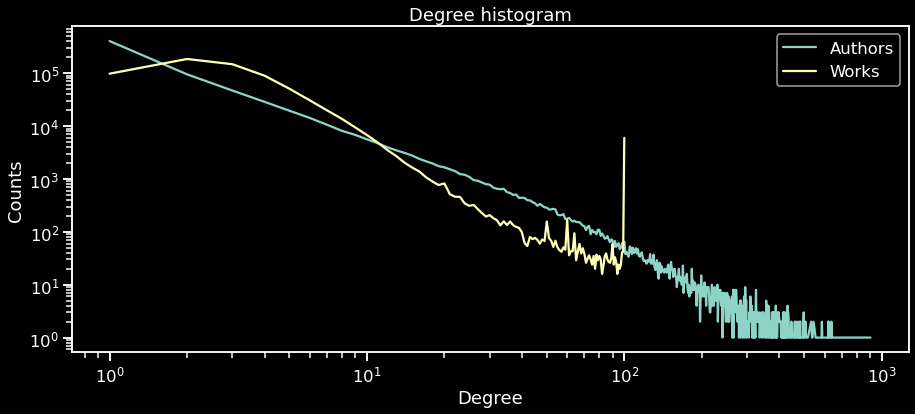

In [79]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(*np.unique(degree_sequence_auth, return_counts=True), label='Authors')
ax.plot(*np.unique(degree_sequence_works, return_counts=True), label='Works')
ax.set_title("Degree histogram");
ax.set_xlabel("Degree");
ax.set_ylabel("Counts");
ax.set_xscale('log');
ax.set_yscale('log');
ax.legend();

In [80]:
# discard works with > 50 authors
K = 50
discard_nodes = [n for n in authorship_g.nodes() if 'W' in n and authorship_g.degree(n) > K]
len(discard_nodes)

8009

In [83]:
authorship_g.remove_nodes_from(discard_nodes)

In [85]:
nx.is_connected(authorship_g)

False

In [88]:
comp_sizes = sorted((len(c) for c in nx.connected_components(authorship_g)), reverse=True)
comp_sizes[: 10]

[1105677, 114, 114, 104, 61, 60, 59, 55, 55, 55]

In [89]:
lcc = max(nx.connected_components(authorship_g), key=len)
lcc_auth_g = authorship_g.subgraph(lcc).copy()

In [90]:
print(authorship_g)
print(lcc_auth_g)

Graph with 1380905 nodes and 2557408 edges
Graph with 1105677 nodes and 2389646 edges


### Read references

In [31]:
refs_g = nx.from_pandas_edgelist(aps_refs_df, source='work_id', target='referenced_work_id', create_using=nx.DiGraph)
print(refs_g)

DiGraph with 498095 nodes and 3162282 edges


In [42]:
# assign weights to citation graph -- if a paper with i authors cite a paper with j authors, weight is 1 / (i * j)
edge_wts = {}

for u, v in refs_g.edges():
    if authorship_g.has_node(u) and authorship_g.has_node(v):
        w = 1 / (authorship_g.degree(u) * authorship_g.degree(v))
    else:
        w = 0
    edge_wts[(u, v)] = w

nx.set_edge_attributes(refs_g, name='weight', values=edge_wts)

In [46]:
zeros = [k for k, v in edge_wts.items() if v == 0]
zeros[: 2]

[('https://openalex.org/W4205280470', 'https://openalex.org/W2915737249'),
 ('https://openalex.org/W4205280470', 'https://openalex.org/W2172168240')]

In [47]:
refs_g.remove_edges_from(zeros)  # remove the 0 weighted edges

In [91]:
author_nodes = [n for n in lcc_auth_g if 'A' in n]
len(author_nodes)

516226

In [92]:
coauth_g = nx.bipartite.weighted_projected_graph(lcc_auth_g, nodes=author_nodes)
print(coauth_g)

Graph with 516226 nodes and 4330591 edges


In [93]:
wts = [v for v in nx.get_edge_attributes(coauth_g, 'weight').values()]
len(wts)

4330591

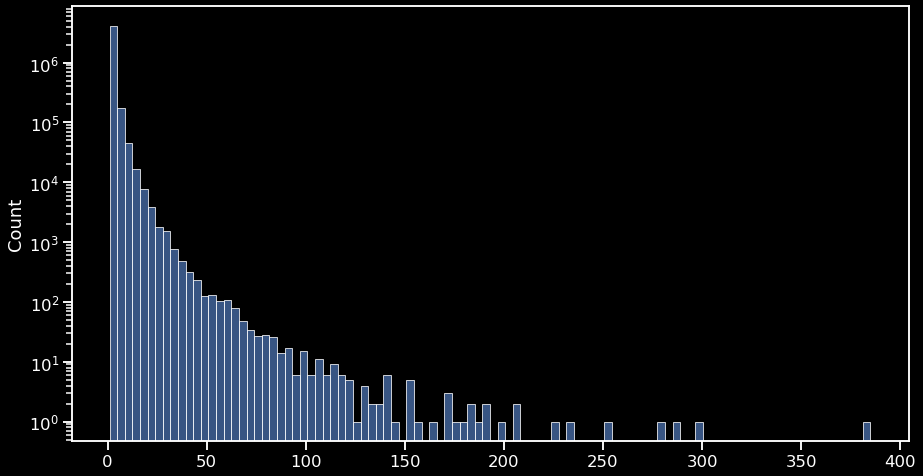

In [96]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(wts, bins=100, ax=ax);
ax.set_yscale('log');